# Table of contents <a id=25></a>
1. [Importing packages](#1)
2. [Importing the dataset from training directory](#2)
    - 2.1 [Data copies](#3)
    - 2.2 [Data Subset](#4)
    - 2.3 [Helper Function](#5)
3. [Data processing](#6)
    - 3.1 [Data Resizing](#7)
    - 3.2 [Mean Blur](#8)
    - 3.3 [Data Resizing and Mean Blur](#9)
    - 3.4 [Train/Test Split](#10)
    - 3.5 [One Hot encoding](#11)
4. [Models](#12)
    - 4.1 [Hyper-Parameter Selection](#13)
    - 4.2 [SVM - Raw Data](#14)
    - 4.3 [SVM - Resized Data](#15)
    - 4.4 [SVM - Mean Blur](#16)
    - 4.5 [SVM - Resized and Mean Blur](#17)
5. [PCA](#18)
    - 5.1 [SVM - PCA](#19)
    - 5.2 [SVM - PCA with Resized Mean Blur](#20)
6. [Convolutional Neural Network](#21)
    - 6.1 [CNN 2-Layers](#22)
    - 6.2 [CNN 5-Layers](#23)
7. [Model Comparison](#24)


# Importing packages <a id=1></a>

In [59]:
# import data processing and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import time

print("Packages imported...")

Packages imported...


# Importing Dataset <a id=2></a>

In [2]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 29

train_len = 87000
train_dir = 'asl_alphabet_train/'

def get_data(folder):
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=np.int)
    cnt = 0
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28           
            else:
                label = 29
            for image_filename in os.listdir(folder + folderName):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file).reshape((-1, imageSize, imageSize, 3))
                    
                    X[cnt] = img_arr
                    y[cnt] = label
                    cnt += 1
    return X,y
X_init, y_init = get_data(train_dir)
print("Images successfully imported...")

C:\Users\pprad\AppData\Local\Temp\ipykernel_23476\2970631385.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.empty((train_len,), dtype=np.int)


Images successfully imported...


### Data copies<a id=3></a>

In [3]:
X_data = X_init
y_data = y_init
print("Copies made...")

Copies made...


### Data Subset <a id=4></a>

In [4]:

# Assuming X_data is a numpy array of shape (N, D) and y_data is a numpy array of shape (N,)
# where N is the number of samples and D is the number of features.

num_classes = 29
num_samples_per_class = 215

X_new = []
y_new = []

for c in range(num_classes):
    indices = np.where(y_data == c)[0]
    indices = np.random.choice(indices, size=num_samples_per_class, replace=False)
    X_new.append(X_data[indices])
    y_new.append(y_data[indices])

X_data = np.vstack(X_new)
y_data = np.hstack(y_new)

### Helper Functions <a id=5></a>

In [5]:
# Flattening the data

import numpy as np

def flat_data(data):
    #########   Train data to flatten ########
    n_samples, height, width, n_channels = data.shape

    # Flatten the image array to have shape (n_samples, n_features)
    n_features = height * width * n_channels
    data_flat = np.reshape(data, (n_samples, n_features))
    
    return data_flat

# Data Preprocessing <a id=6></a>

### Data Resizing <a id=7></a>

In [6]:
# Resized Image Data

new_size = (28, 28)

# Create an empty array to store the resized images
resized_images = np.zeros((X_data.shape[0], new_size[0], new_size[1], 3))

# Loop over each image in the dataset
for i in range(X_data.shape[0]):
    # Resize the image
    resized_images[i] = resize(X_data[i], new_size, mode='reflect', anti_aliasing=True)

### Mean Blur <a id=8></a>

In [7]:
#Mean blur
mean_blur_img = np.zeros(X_data.shape)
ksize = (3, 3)
for i in range(len(X_data)):
    img = X_data[i]
    img = cv2.blur(img, ksize, 0)
    mean_blur_img[i] = img

print("The shape of X_train is : ", mean_blur_img.shape)


The shape of X_train is :  (6235, 64, 64, 3)


### Mean blur and Resizing <a id=9></a>

In [8]:
# Mean Blur with Resized Image

resized_mean_blur_img = np.zeros(resized_images.shape)
ksize = (3, 3)
for i in range(len(resized_images)):
    img = resized_images[i]
    img = cv2.blur(img, ksize, 0)
    resized_mean_blur_img[i] = img

print("The shape of X_train is : ", resized_mean_blur_img.shape)

The shape of X_train is :  (6235, 28, 28, 3)


### Test-Train Split <a id=10></a>

In [9]:
X_train_resized, X_test_resized, y_train, y_test = train_test_split(resized_images, y_data, test_size=0.3,random_state=42,stratify=y_data)

In [10]:
X_train_mean, X_test_mean, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

In [11]:
X_train_resized_mean, X_test_resized_mean, y_train, y_test = train_test_split(resized_mean_blur_img, y_data, test_size=0.3,random_state=42,stratify=y_data)

In [12]:
X_train_original, X_test_original, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

### One-hot Encoding of Label <a id=11></a>

In [13]:
from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train,29)
y_cat_test = to_categorical(y_test,29)

# Model Building <a id=12></a>

### SVM Hyperparameter Search <a id=13></a>

In [14]:
pipe = Pipeline([('svc', SVC())])

param_grid = [{'svc': [SVC()],
              'svc__kernel': ['linear', 'poly', 'rbf'], 
              'svc__C': [1,10,100]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(flat_data(X_train_resized), y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.78
Best parameters:
{'svc': SVC(C=100), 'svc__C': 100, 'svc__kernel': 'rbf'}


In [15]:
y_pred_test = grid.predict(flat_data(X_test_resized))
svm_resized_acc = accuracy_score(y_test, y_pred_test)
svm_resized_acc

0.797434526990914

### SVM with Raw Data <a id=14></a>

In [16]:
start = time.time()

svc = SVC(kernel='rbf', C=100)
svc.fit(flat_data(X_train_original),y_train)
y_pred = svc.predict(flat_data(X_test_original))

end = time.time()

svm_orig_acc = accuracy_score(y_test, y_pred)
svm_orig_time = end-start

print(f'SVM with mean blur: \nExecution Time: {end-start} \nAccuracy Score: {svm_orig_acc}')

SVM with mean blur: 
Execution Time: 726.2985897064209 
Accuracy Score: 0.7899518973810796


### SVM with Resized Data <a id=15></a>

In [17]:
start = time.time()

svc = SVC(kernel='rbf', C=100)
svc.fit(flat_data(X_train_resized),y_train)
y_pred = svc.predict(flat_data(X_test_resized))

end = time.time()

svm_resized_acc = accuracy_score(y_test, y_pred)
svm_resized_time = end-start

print(f'SVM with mean blur: \nExecution Time: {end-start} \nAccuracy Score: {svm_resized_acc}')

SVM with mean blur: 
Execution Time: 24.399134874343872 
Accuracy Score: 0.797434526990914


### SVM with Mean Blur <a id=16></a>

In [18]:
start = time.time()

svc = SVC(kernel='rbf', C=100)
svc.fit(flat_data(X_train_mean),y_train)
y_pred = svc.predict(flat_data(X_test_mean))

end = time.time()

svm_mean_acc = accuracy_score(y_test, y_pred)
svm_mean_time = end-start

print(f'SVM with mean blur: \nExecution Time: {end-start} \nAccuracy Score: {svm_mean_acc}')

SVM with mean blur: 
Execution Time: 547.2798175811768 
Accuracy Score: 0.7899518973810796


### SVM with Resized image and Mean blur <a id=17></a>

In [19]:
start = time.time()

svc = SVC(kernel='rbf', C=100)
svc.fit(flat_data(X_train_resized_mean),y_train)
y_pred = svc.predict(flat_data(X_test_resized_mean))

end = time.time()

svm_resized_mean_acc = accuracy_score(y_test, y_pred)
svm_resized_mean_acc

svm_resized_mean_time = end-start

print(f'SVM with Resized Image and Mean Blur: \
      \nExecution Time: {svm_resized_mean_time} \
      \nAccuracy Score: {svm_resized_mean_acc}')

SVM with Resized Image and Mean Blur:       
Execution Time: 15.779603719711304       
Accuracy Score: 0.8321753073222875


# PCA - Feature Selection <a id=18></a>

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_rescaled = scaler.fit_transform(flat_data(X_train_original))
X_test_rescaled = scaler.transform(flat_data(X_test_original))


The optimal number of components for variance threshold 0.95 is 90


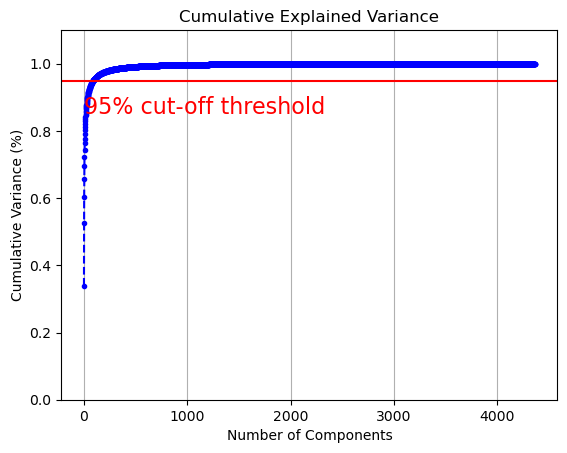

In [21]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components = 0.96)
pca1.fit_transform(X_train_rescaled)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, (len(np.cumsum(pca1.explained_variance_ratio_))+1))
y = np.cumsum(pca1.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='.', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 140, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()
 

**Value of PCA component calculation varies with each run, we have taken value which is mode of all itterations, i.e. value which is repeated more times in all the runs. This value is 100, hence we have used PCA components = 100**

### SVM with PCA <a id=19></a>

In [22]:
components = 100 
pca = PCA(n_components = components)
pca.fit(X_train_rescaled)

X_train_pca = pca.transform(X_train_rescaled)
X_test_pca = pca.transform(X_test_rescaled)



In [23]:
start = time.time()

svc = SVC(kernel='rbf', C=100)
svc.fit(X_train_pca,y_train)
y_pred = svc.predict(X_test_pca)

end = time.time()

svm_pca_acc = accuracy_score(y_test, y_pred)
svm_pca_acc

svm_pca_time = end-start

print(f'SVM with PCA: \
      \nExecution Time: {svm_pca_time} \
      \nAccuracy Score: {svm_pca_acc}')

SVM with PCA:       
Execution Time: 1.3116862773895264       
Accuracy Score: 0.8102618920363442


### SVM with PCA Resized and Mean Normalized <a id=20></a>

In [24]:
pca2 = PCA(n_components = 100)
pca2.fit(flat_data(X_train_resized_mean))

X_train_pca_rm = pca2.transform(flat_data(X_train_resized_mean))
X_test_pca_rm = pca2.transform(flat_data(X_test_resized_mean))

In [25]:
start = time.time()

svc = SVC(kernel='rbf', C=100)
svc.fit(X_train_pca_rm,y_train)
y_pred = svc.predict(X_test_pca_rm)

end = time.time()

svm_pca_rm_acc = accuracy_score(y_test, y_pred)
svm_pca_rm_acc

svm_pca_rm_time = end-start

print(f'SVM with PCA Resized and Mean Normalized: \
      \nExecution Time: {svm_pca_rm_time} \
      \nAccuracy Score: {svm_pca_rm_acc}')

SVM with PCA Resized and Mean Normalized:       
Execution Time: 1.230196475982666       
Accuracy Score: 0.8295029396044896


# Convolutional Neural Network <a id=21></a>

### CNN with 2 Layers <a id=22></a>

In [51]:
cnn_2 = Sequential()

cnn_2.add(Conv2D(16, (3, 3), input_shape=(64, 64, 3)))
cnn_2.add(BatchNormalization())
cnn_2.add(Activation('relu'))
cnn_2.add(MaxPooling2D((2, 2)))

cnn_2.add(Flatten())
cnn_2.add(Dense(29, activation='softmax'))

cnn_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 batch_normalization_3 (Batc  (None, 62, 62, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 62, 62, 16)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 15376)             0         
                                                                 
 dense_5 (Dense)             (None, 29)               

In [52]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [53]:
cnn_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
start = time.time()
history_cnn_2 = cnn_2.fit(X_train_original, y_cat_train,
          epochs=30,
          batch_size=64,
          verbose=2,
          validation_data=(X_test_original, y_cat_test))
end = time.time()

cnn_2_time = end-start

print(f'time: {end-start}')


AttributeError: 'float' object has no attribute 'time'

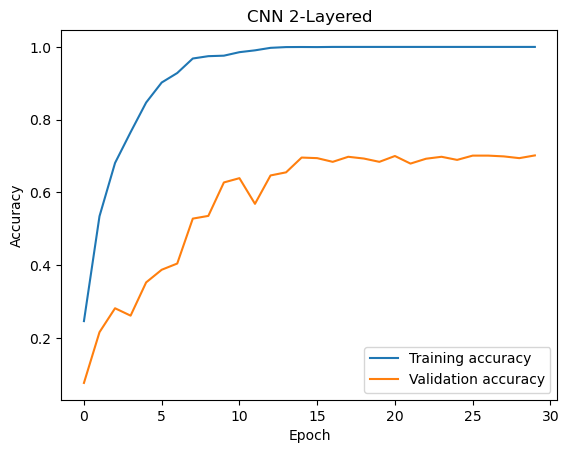

In [46]:
train_acc = history_cnn_2.history['accuracy']
val_acc = history_cnn_2.history['val_accuracy']

# Create a plot of the training and validation accuracy over epochs
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN 2-Layered')
plt.show()

In [47]:
_, test_acc_cnn_2 = cnn_2.evaluate(X_test_original, y_cat_test , verbose=0)

test_acc_cnn_2

0.7017637491226196

### CNN with 5 Layers <a id=23></a>

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization

cnn_5 = Sequential()

cnn_5.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
cnn_5.add(BatchNormalization())
cnn_5.add(Activation('relu'))
cnn_5.add(MaxPooling2D((2, 2)))

cnn_5.add(Conv2D(64, (3, 3)))

cnn_5.add(Activation('relu'))
cnn_5.add(MaxPooling2D((2, 2)))

cnn_5.add(Conv2D(64, (3, 3)))

cnn_5.add(Activation('relu'))
cnn_5.add(MaxPooling2D((2, 2)))

cnn_5.add(Flatten())

cnn_5.add(Dense(128, activation='relu'))

cnn_5.add(Dense(29, activation='softmax'))

cnn_5.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 batch_normalization_2 (Batc  (None, 60, 60, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 28, 28, 64)       

In [49]:
cnn_5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
start = time.time()
history_cnn_5 = cnn_5.fit(X_train_original, y_cat_train,
          epochs=40,
          batch_size=64,
          verbose=2,
          validation_data=(X_test_original, y_cat_test))
end = time.time()

cnn_5_time = end-start

print(f'time: {end-start}')

Epoch 1/40
69/69 - 8s - loss: 2.9532 - accuracy: 0.1797 - val_loss: 3.2785 - val_accuracy: 0.0652 - 8s/epoch - 110ms/step
Epoch 2/40
69/69 - 7s - loss: 1.6268 - accuracy: 0.5188 - val_loss: 2.9574 - val_accuracy: 0.1705 - 7s/epoch - 99ms/step
Epoch 3/40
69/69 - 7s - loss: 0.9151 - accuracy: 0.7152 - val_loss: 2.9820 - val_accuracy: 0.1603 - 7s/epoch - 99ms/step
Epoch 4/40
69/69 - 7s - loss: 0.5879 - accuracy: 0.8139 - val_loss: 2.3815 - val_accuracy: 0.3191 - 7s/epoch - 97ms/step
Epoch 5/40
69/69 - 7s - loss: 0.3384 - accuracy: 0.8930 - val_loss: 2.0243 - val_accuracy: 0.4067 - 7s/epoch - 97ms/step
Epoch 6/40
69/69 - 7s - loss: 0.2572 - accuracy: 0.9219 - val_loss: 1.0647 - val_accuracy: 0.6638 - 7s/epoch - 96ms/step
Epoch 7/40
69/69 - 7s - loss: 0.1827 - accuracy: 0.9464 - val_loss: 0.9104 - val_accuracy: 0.7402 - 7s/epoch - 102ms/step
Epoch 8/40
69/69 - 8s - loss: 0.1127 - accuracy: 0.9659 - val_loss: 0.7639 - val_accuracy: 0.7755 - 8s/epoch - 111ms/step
Epoch 9/40
69/69 - 7s - loss:

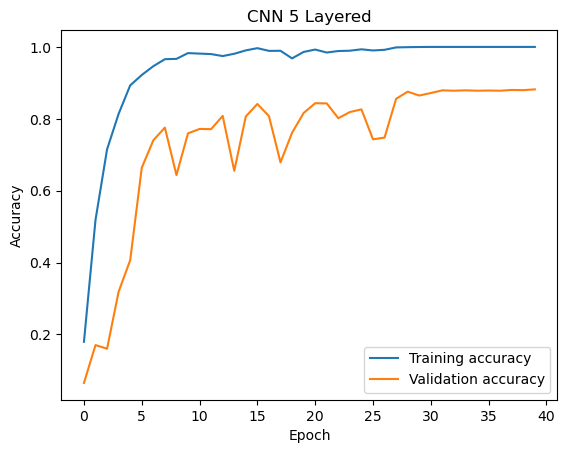

In [61]:
train_acc = history_cnn_5.history['accuracy']
val_acc = history_cnn_5.history['val_accuracy']

# Create a plot of the training and validation accuracy over epochs
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN 5 Layered')
plt.show()

In [62]:
_, test_acc_cnn_5 = cnn_5.evaluate(X_test_original, y_cat_test , verbose=0)

test_acc_cnn_5

0.8818813562393188

# Model Comparison <a id=24></a>

In [63]:
method = ['SVM; Original (64X64)','SVM; Resized (28X28)','SVM; Mean (64X64)',
          'SVM; Resized and mean Normalization (28X28)', 'SVM; PCA (64X64)',
         'SVM; Resized, mean normalization, PCA (28X28)', 'CNN; 2 Layered', 'CNN; 5 Layered']

data = [{'Accuracy':svm_orig_acc , 'Excecution Time': svm_orig_time},
        {'Accuracy':svm_resized_acc , 'Excecution Time': svm_resized_time},
        {'Accuracy':svm_mean_acc , 'Excecution Time': svm_mean_time},
        {'Accuracy': svm_resized_mean_acc, 'Excecution Time': svm_resized_mean_time},
        {'Accuracy': svm_pca_acc, 'Excecution Time': svm_pca_time},
        {'Accuracy': svm_pca_rm_acc, 'Excecution Time': svm_pca_rm_time},
        {'Accuracy': test_acc_cnn_2, 'Excecution Time': cnn_2_time},
        {'Accuracy': test_acc_cnn_5, 'Excecution Time': cnn_5_time}]
df = pd.DataFrame(data,index = method)

C:\Users\pprad\AppData\Local\Temp\ipykernel_23476\2681149432.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([model.replace(' ', '\n') for model in df.index]);


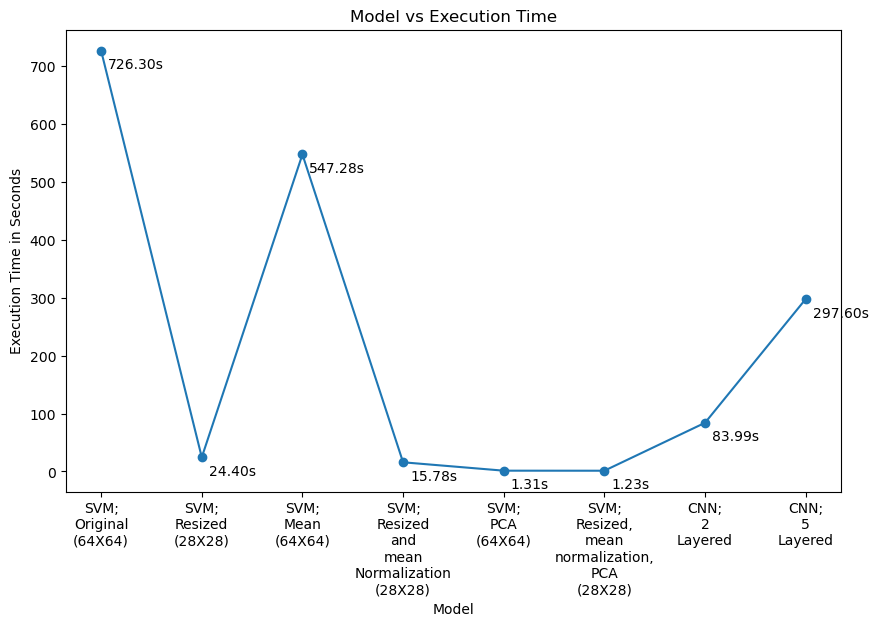

In [67]:
fig1, ax1 = plt.subplots(figsize=(10, 6 ))
plt.plot(df.index,df['Excecution Time'], marker = 'o');

ax1.set_xticklabels([model.replace(' ', '\n') for model in df.index]);


plt.ylabel('Execution Time in Seconds')
plt.xlabel('Model')
plt.title('Model vs Execution Time');

for i, time1 in enumerate(df['Excecution Time']):
    ax1.annotate(f'{time1:.2f}s', xy=(df.index[i], time1), xytext=(5, -10), 
                 textcoords='offset points', ha='left', va='center')

C:\Users\pprad\AppData\Local\Temp\ipykernel_23476\643161950.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model.replace(' ', '\n') for model in df.index]);


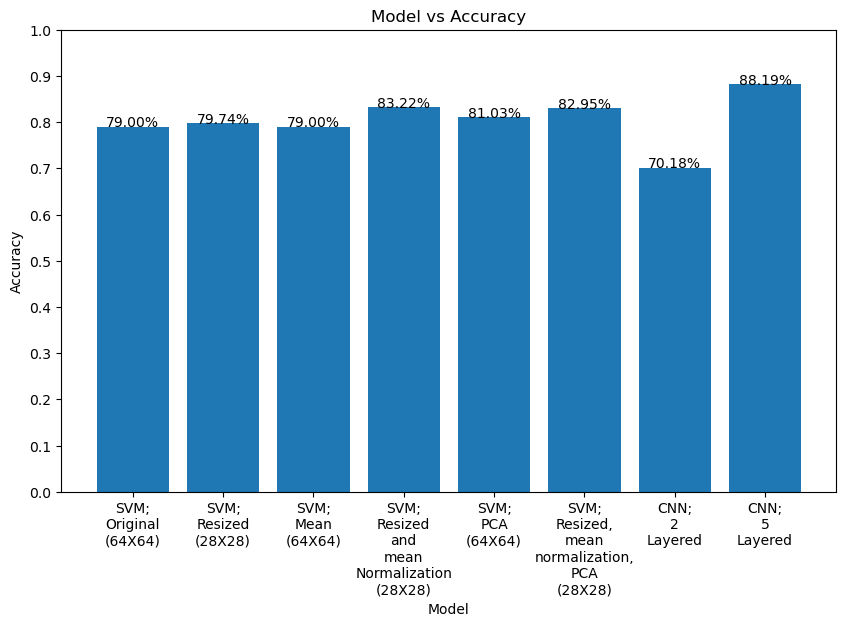

In [68]:
fig, ax = plt.subplots(figsize=(10, 6 ))
plt.bar(df.index,df['Accuracy']);
# add percentages to the top of the bars
for i, v in enumerate(df['Accuracy']):
    ax.text(i, v, f'{v:.2%}', ha='center')

ax.set_xticklabels([model.replace(' ', '\n') for model in df.index]);

plt.ylabel('Accuracy');
plt.xlabel('Model');
y_ticks = np.arange(0, 1.1, 0.1)
ax.set_ylim([0, 1])
ax.set_yticks(y_ticks)

plt.title('Model vs Accuracy');


**All the Outputs are noted with runing the notebook multiple times and on different systems. 
The Average accuracy of the Model CNN - 5 layered model is 91%, which is the highest test accuracy for this project.
Detailed model results are mentioned in the report.**